## Use photonic crystal slab as test-bed
Thus far, the photonic crystal slab seems like the worst case for convergence.
Based on my experiments, the ilu preconditioner doesn't seem to work great for 3D FDFD...most likely the sparsity imposed on the ilu is simply too great for the incomplete factorization to capture anything meaningful

## Notes
1. ilu factorization for matrices this size seems prohibitive...

Problematically, the ilu factorization can only be applied by doing back-substitution...which I guess is not ideal...
though I wonder if there's a better way

2. Modified ilu using only diagonal blocks (based on a paper, "An efficient ilu preconditioning for highly sparse matrices constructed using FDFD method"...also doesn't seem as great as it promises, but at the same time, it's not easy to implement exactly using scipy's infrastructure...

3. Actually switching solvers to scipy's lgmres seems to improve a lot, but lgmres is a lot slower than bicgstab or qmr

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '32'
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import math
import sys
sys.path.append('../')
from pyfd3d import pyfd3d
from pyMKL import pardisoSolver
import pyfd3d.fd3d as fd3d
from scipy.sparse.linalg import qmr, bicgstab, gmres, lgmres, gcrotmk

In [2]:
Nz = 111
Npml = np.array([0,0,10])

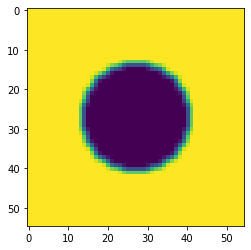

In [3]:
L0 = 1e-6
## specify slab plane
xrange = yrange = np.array([-0.5,0.5])
zrange = [-1,1];
radius = 0.25
Nx = Ny = 55

x = np.linspace(xrange[0], xrange[1], Nx)
y = np.linspace(yrange[0], yrange[1], Ny)
z = np.linspace(zrange[0], zrange[1], Nz)
xx,yy = np.meshgrid(x,y)

slab_plane = 4*np.ones((Nx,Ny))

slab_plane[xx**2+yy**2<radius**2] = 1

## artificial averaging?
slab_plane = (slab_plane+np.roll(slab_plane, shift= 1, axis = 1))/2
slab_plane = (slab_plane+np.roll(slab_plane, shift= 1, axis = 0))/2
slab_plane = (slab_plane+np.roll(slab_plane, shift= -1, axis = 1))/2
slab_plane = (slab_plane+np.roll(slab_plane, shift= -1, axis = 0))/2
plt.imshow(slab_plane)

In [4]:
## integrate slab structure into 3D grid
eps_r = np.ones((Nx,Ny,Nz))
N = [Nx,Ny,Nz]

In [5]:
print(eps_r.shape)
for k in range(50,80):
    eps_r[:,:,k] = slab_plane

(55, 55, 111)


In [6]:
Jz = np.zeros(N); 
Jy = np.zeros(N);
Jx = np.zeros(N);
Jx[:,:,15] = 1;
Jy[:,:,15] = 1
eps_r_tensor_dict = {
    'eps_xx': eps_r,
    'eps_yy': eps_r.copy(),
    'eps_zz': eps_r.copy(),
}
JCurrentVector = {
    'Jx': Jx,
    'Jy': Jy,
    'Jz': Jz
}


In [7]:
wvlen = 0.51;
print(L0, xrange, yrange, zrange)

A,b, Ch = fd3d.curlcurlE(L0, 
                         wvlen, 
                         xrange, 
                         yrange, 
                         zrange, 
                         eps_r_tensor_dict, 
                         JCurrentVector,Npml, 
                         s = -1
                        )

1e-06 [-0.5  0.5] [-0.5  0.5] [-1, 1]
(1007325,)


In [8]:
%%time
## ilu preconditioner, this is already relatively slow to form
from scipy.sparse.linalg import LinearOperator, spilu
# ilu = spilu(A, fill_factor = 2.0) #fill_factor 1 uses same sparsity as A
# Mx = lambda x: ilu.solve(x)
#M = LinearOperator((3*Nx*Ny*Nz, 3*Nx*Ny*Nz), Mx)

CPU times: user 43 µs, sys: 2 µs, total: 45 µs
Wall time: 28.8 µs


In [9]:
%%time
Axx = A[0:Nx*Ny*Nz, 0:Nx*Ny*Nz]
Ayy =  A[Nx*Ny*Nz:2*Nx*Ny*Nz, Nx*Ny*Nz:2*Nx*Ny*Nz]
Azz =  A[2*Nx*Ny*Nz:, 2*Nx*Ny*Nz:]
print(Axx.shape, Ayy.shape, Azz.shape)

## seperately ilu each block
ilux = spilu(Axx, fill_factor = 1.0) #fill_factor 1 uses same sparsity as A
print('done x')
iluy = spilu(Ayy, fill_factor = 1.0) #fill_factor 1 uses same sparsity as A
print('done y')
iluz = spilu(Azz, fill_factor = 1.0) #fill_factor 1 uses same sparsity as A
print('done all')

(335775, 335775) (335775, 335775) (335775, 335775)


/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:407: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


done x
done y
done all
CPU times: user 57.6 s, sys: 1.3 s, total: 58.9 s
Wall time: 58.8 s


In [10]:
%%time
from scipy.sparse.linalg import spsolve_triangular
print(dir(ilux))
Lx, Ux, pcx, prx = ilux.L, ilux.U, ilux.perm_c, ilux.perm_r
Ly, Uy, pcy, pry = iluy.L, iluy.U, iluy.perm_c, iluy.perm_r
Lz, Uz, pcz, prz = iluz.L, iluz.U, iluz.perm_c, iluz.perm_r

m = Nx*Ny*Nz
Pcx, Prx = sp.csc_matrix((np.ones(m), (prx, np.arange(m)))),sp.csc_matrix((np.ones(m), (np.arange(m), pcx)))
Pcy, Pry = sp.csc_matrix((np.ones(m), (pry, np.arange(m)))),sp.csc_matrix((np.ones(m), (np.arange(m), pcy)))
Pcz, Prz = sp.csc_matrix((np.ones(m), (prz, np.arange(m)))),sp.csc_matrix((np.ones(m), (np.arange(m), pcz)))

['L', 'U', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'nnz', 'perm_c', 'perm_r', 'shape', 'solve']
CPU times: user 237 ms, sys: 43.2 ms, total: 280 ms
Wall time: 279 ms


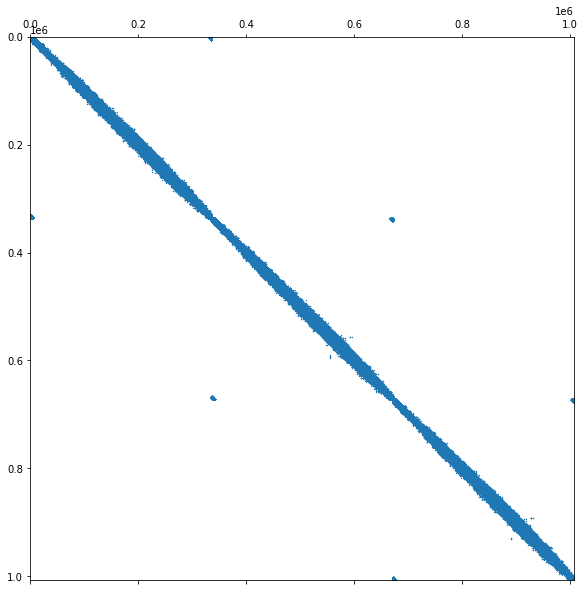

In [11]:
#create bloc diagonal factors
Lblock = sp.block_diag((Lx, Ly, Lz))
Ublock = sp.block_diag((Ux, Uy, Uz))
#     lsolve = spsolve_triangular(Lblock, x, lower = True)
#     usolve = spsolve_triangular(Ublock, lsolve, lower = False)
Pcblock = sp.block_diag((Pcx, Pcy, Pcz))
Prblock = sp.block_diag((Prx, Pry, Prz))

Ablock = Prblock*(Lblock@Ublock)*Pcblock
plt.figure(figsize = (10,10))
plt.spy(Ablock, markersize = 0.4)




In [12]:
# %%time
# Ablock = sp.block_diag((Axx, Ayy, Azz))

# ## convert to csc format for spilu
# Ablock = sp.csc_matrix(Ablock)
# ilub = spilu(Ablock, fill_factor = 5.0)

# def block_ilu_solve(x):
#     return ilub.solve(x)


In [13]:
# plt.figure() #check  iluB is block diagonal
# plt.spy(ilub.L, markersize = 0.1)
# print(ilub.L.count_nonzero())

In [14]:
# %%time
# #test
# block_ilu_solve(b)

In [15]:
# %%time
# ilu.solve(b)

In [16]:
# ## construct backsub operator
# Mop = LinearOperator((3*Nx*Ny*Nz, 3*Nx*Ny*Nz), block_ilu_solve)

In [17]:
#preserved_x = x;

In [ ]:
%%time
#x, info = lgmres(A,b, x0 = x,maxiter = 10, atol = 1e-3) 
x, info = gcrotmk(A,b,maxiter = 2000, atol = 1e-3)
print(info)

In [ ]:
print(info) #system did not converge if info is not 0... <0 is the worse because it means iteration broke...

In [ ]:
y = Ch@x
print(y.shape, A.shape)

In [ ]:
print('error norm: ',np.linalg.norm(A@x-b)/np.linalg.norm(b))
print(np.linalg.norm(b), np.linalg.norm(A@x))
print('error norm should be small, ideally close to precision')
plt.plot(np.abs(A@x))
plt.plot(np.abs(b))



In [ ]:
M = np.prod(N);
Ex = x[0:M].reshape(N, order = 'F');
Ey = x[M:2*M].reshape(N, order = 'F')
Ez = x[2*M:].reshape(N, order = 'F')

Hx =  y[0:M].reshape(N, order = 'F')
Hy =  y[M:2*M].reshape(N, order = 'F')
Hz =  y[2*M:].reshape(N, order = 'F')


In [ ]:
plt.figure();
plt.imshow(eps_r[:,25,:])
for i in range(0,N[0],2):
    plt.figure()
    plt.imshow(np.abs(Ey[:,i,:]), cmap = 'hot')
    #plt.imshow(np.real(Ey[:,i,:]), cmap = 'RdBu')

    #plt.clim(-4,4)
    plt.colorbar()
    

In [ ]:
for i in range(0,N[-1],2):
    plt.figure()
    plt.imshow(np.real(Ex[:,:,i]), cmap = 'RdBu')
    #plt.clim(0,0.5e-2)
    plt.colorbar()

In [ ]:
print(np.allclose(A@x, b))

In [ ]:
plt.plot(np.abs(x))